<a href="https://colab.research.google.com/github/saishdesai23/Sales_Forecasting/blob/main/forecasting_with_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Store-Item Demand Forcasting Challenge

### Description
#### This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.
#### You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.


### Summary

#### This report details the predictive modeling approach for a store item demand forecasting competition using LightGBM, a gradient boosting framework optimized for efficiency and performance. The objective is to forecast sales for various items across different stores, taking into account the seasonal patterns and unique characteristics of store-item combinations. The process is underpinned by rigorous exploratory data analysis, feature engineering, and a two-phase optimization of the LightGBM model.



# Approach : LightGBM
#### LightGBM is a gradient boosting framework that uses tree-based learning algorithms and is designed for distributed and efficient training, particularly on large datasets.

#### It stands out for its use of a histogram-based algorithm that groups continuous feature values into discrete bins, which speeds up training and reduces memory usage. LightGBM supports parallel and GPU learning, and has an efficient implementation of the leaf-wise growth strategy for decision trees, which often results in better performance with less memory consumption compared to depth-wise growth strategies.

#### Its high performance and fast execution speeds makes it a viable model to predict the store item demand.


## Library Installation

In [4]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.6 MB/s eta 0:00:00


## Connecting to google drive

In [2]:
# connecting google drive to the notebook
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


## Importing Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [5]:
# Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model
import lightgbm as lgb
import shap
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Data
#### Variables:
##### - date
##### - store
##### - item
##### - sales

In [6]:
train = pd.read_csv('/content/gdrive/MyDrive/Time Series Analysis/data/train.csv', parse_dates=['date'])
df = train
# test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
# df = pd.concat([train, test], sort=False)

# print(train.shape, test.shape, df.shape, "\n")
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


# Exploratory Data Analysis


## Sales Analysis:
#### Analyzing sales data per store and item, including summary statistics like mean, median, standard deviation, minimum, and maximum sales.

In [7]:
# How many items are in the store?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [8]:
# Summary Stats for each item
df.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                               
      count      sum       mean median        std min  max
item                                                      
1     18260   401384  21.981599   21.0   8.468922   1   59
2     18260  1069564  58.574151   56.0  20.093015   9  150
3     18260   669087  36.642223   35.0  13.179441   7  104
4     18260   401907  22.010241   21.0   8.403898   0   66
5     18260   335230  18.358708   18.0   7.265167   1   50
6     18260  1068281  58.503888   56.0  20.174898  11  148
7     18260  1068777  58.531051   56.0  20.146002  11  141
8     18260  1405108  76.950055   74.0  26.130697  15  181
9     18260   938379  51.389869   49.5  17.790158   6  134
10    18260  1337133  73.227437   70.0  24.823725  14  175
11    18260  1271925  69.656353   67.0  23.744732  11  170
12    18260  1271534  69.634940   67.0  23.738663  12  170
13    18260  1539621  84.316594   81.0  28.311031  20  210
14    18260  1071531  58.681873   56.0  20.079860  12  152
15    18260  1607442  88.030778   85.0  29.522852  17  231
16    18260   468480  25.656079   25.0   9.603270   2   70
17    18260   602486  32.994852   32.0  11.967610   4   83
18    18260  1538876  84.275794   81.0  28.430621  18  208
19    18260   736892  40.355531   39.0  14.332645   5   99
20    18260   867641  47.515936   46.0  16.490487   9  127
21    18260   736190  40.317087   39.0  14.338006   7  109
22    18260  1469971  80.502245   78.0  27.118163  14  214
23    18260   534979  29.297864   28.0  10.819549   3   81
24    18260  1205975  66.044633   64.0  22.531555  14  156
25    18260  1473334  80.686418   78.0  27.238817  18  193
26    18260   869981  47.644085   46.0  16.723912   8  119
27    18260   402628  22.049726   21.0   8.461641   1   59
28    18260  1604713  87.881325   85.0  29.501781  16  206
29    18260  1271240  69.618839   67.0  23.635631  15  173
30    18260   736554  40.337021   39.0  14.363331   5  115
31    18260  1070845  58.644304   57.0  20.104705  10  159
32    18260   803107  43.981763   42.0  15.574556   5  119
33    18260  1270183  69.560953   67.0  23.718343  15  169
34    18260   469935  25.735761   25.0   9.617910   2   79
35    18260  1201541  65.801807   63.0  22.461990  12  168
36    18260  1406548  77.028916   74.0  26.067440  16  188
37    18260   534258  29.258379   28.0  10.771547   3   74
38    18260  1470330  80.521906   77.0  27.141799  15  188
39    18260   801311  43.883406   42.0  15.511550   7  112
40    18260   534094  29.249398   28.0  10.822959   3   74
41    18260   401759  22.002136   21.0   8.402470   2   60
42    18260   669925  36.688116   35.0  13.215112   5   96
43    18260   936635  51.294359   49.0  17.801008   9  126
44    18260   536811  29.398193   28.0  10.797738   3   78
45    18260  1471467  80.584173   78.0  27.318402  18  205
46    18260  1070764  58.639869   56.0  20.220879  11  150
47    18260   401781  22.003341   21.0   8.420102   2   61
48    18260   937703  51.352848   49.0  17.881917   8  130
49    18260   535663  29.335323   28.0  10.874788   3   77
50    18260  1203009  65.882202   63.0  22.416031  12  164

### Histogram: Store Sales

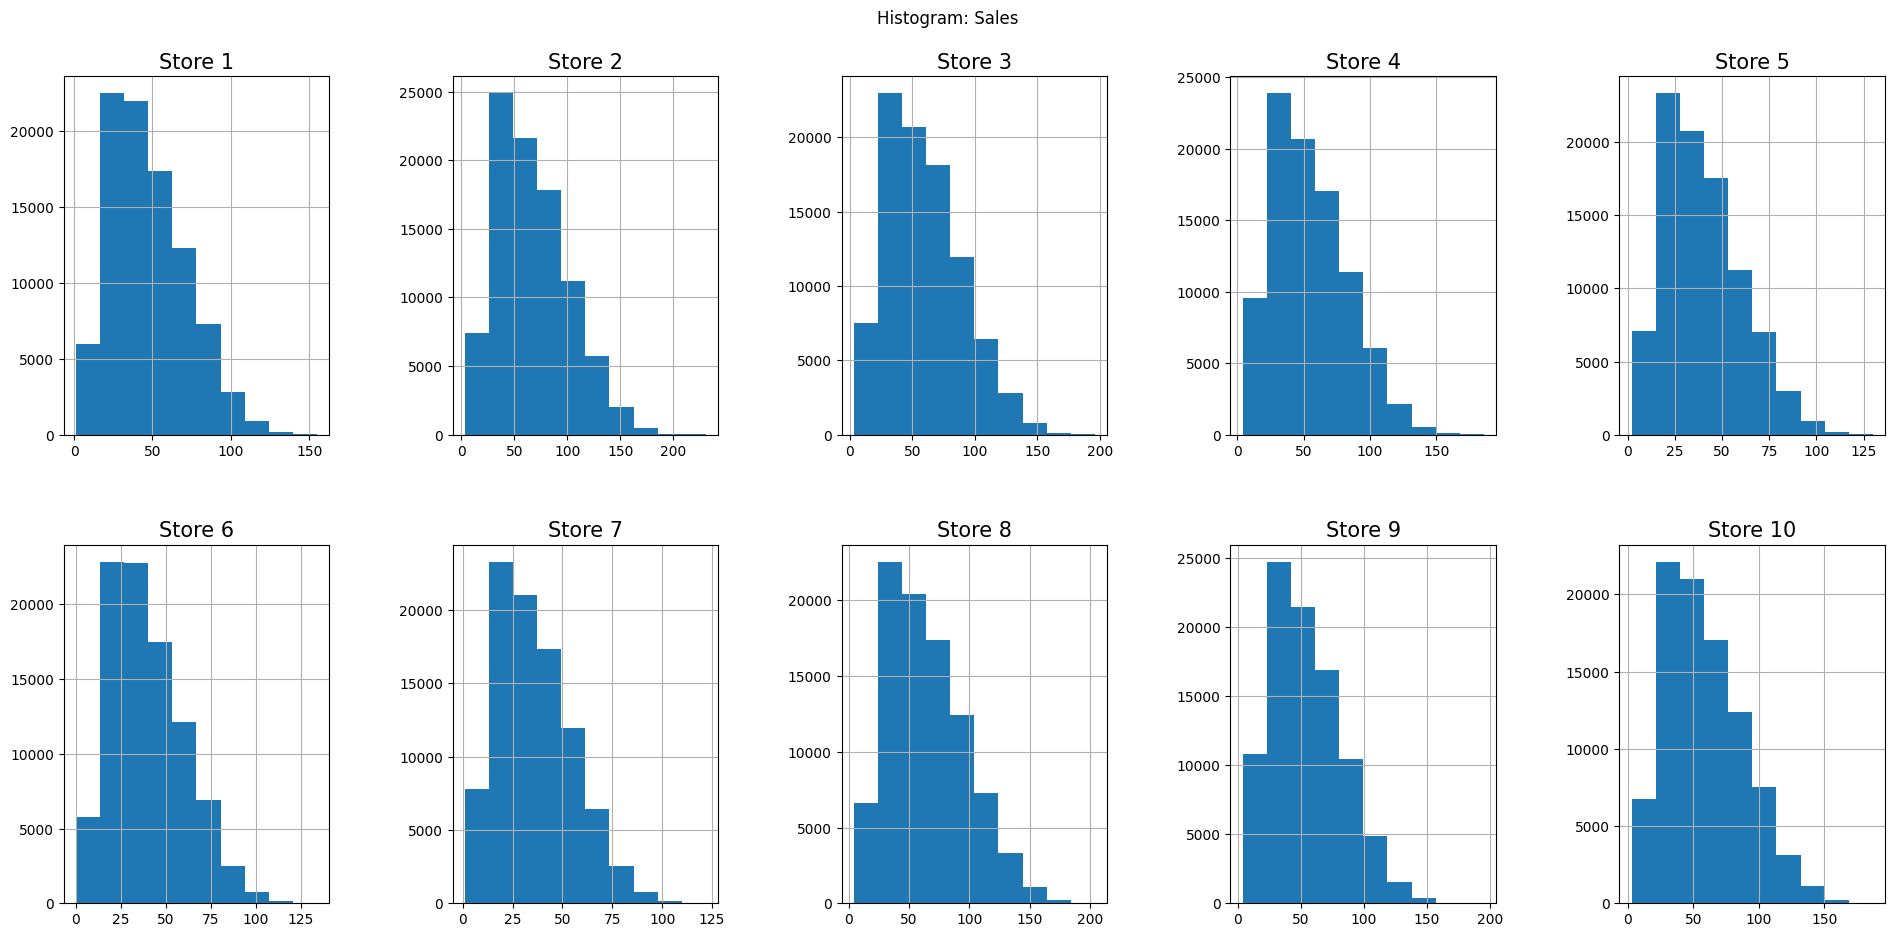

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i in range(1,11):
    if i < 6:
        train[train.store == i].sales.hist(ax=axes[0, i-1])
        axes[0,i-1].set_title("Store " + str(i), fontsize = 15)

    else:
        train[train.store == i].sales.hist(ax=axes[1, i - 6])
        axes[1,i-6].set_title("Store " + str(i), fontsize = 15)
plt.tight_layout(pad=4.5)
plt.suptitle("Histogram: Sales");

### Sales distribution for each item in Store 1


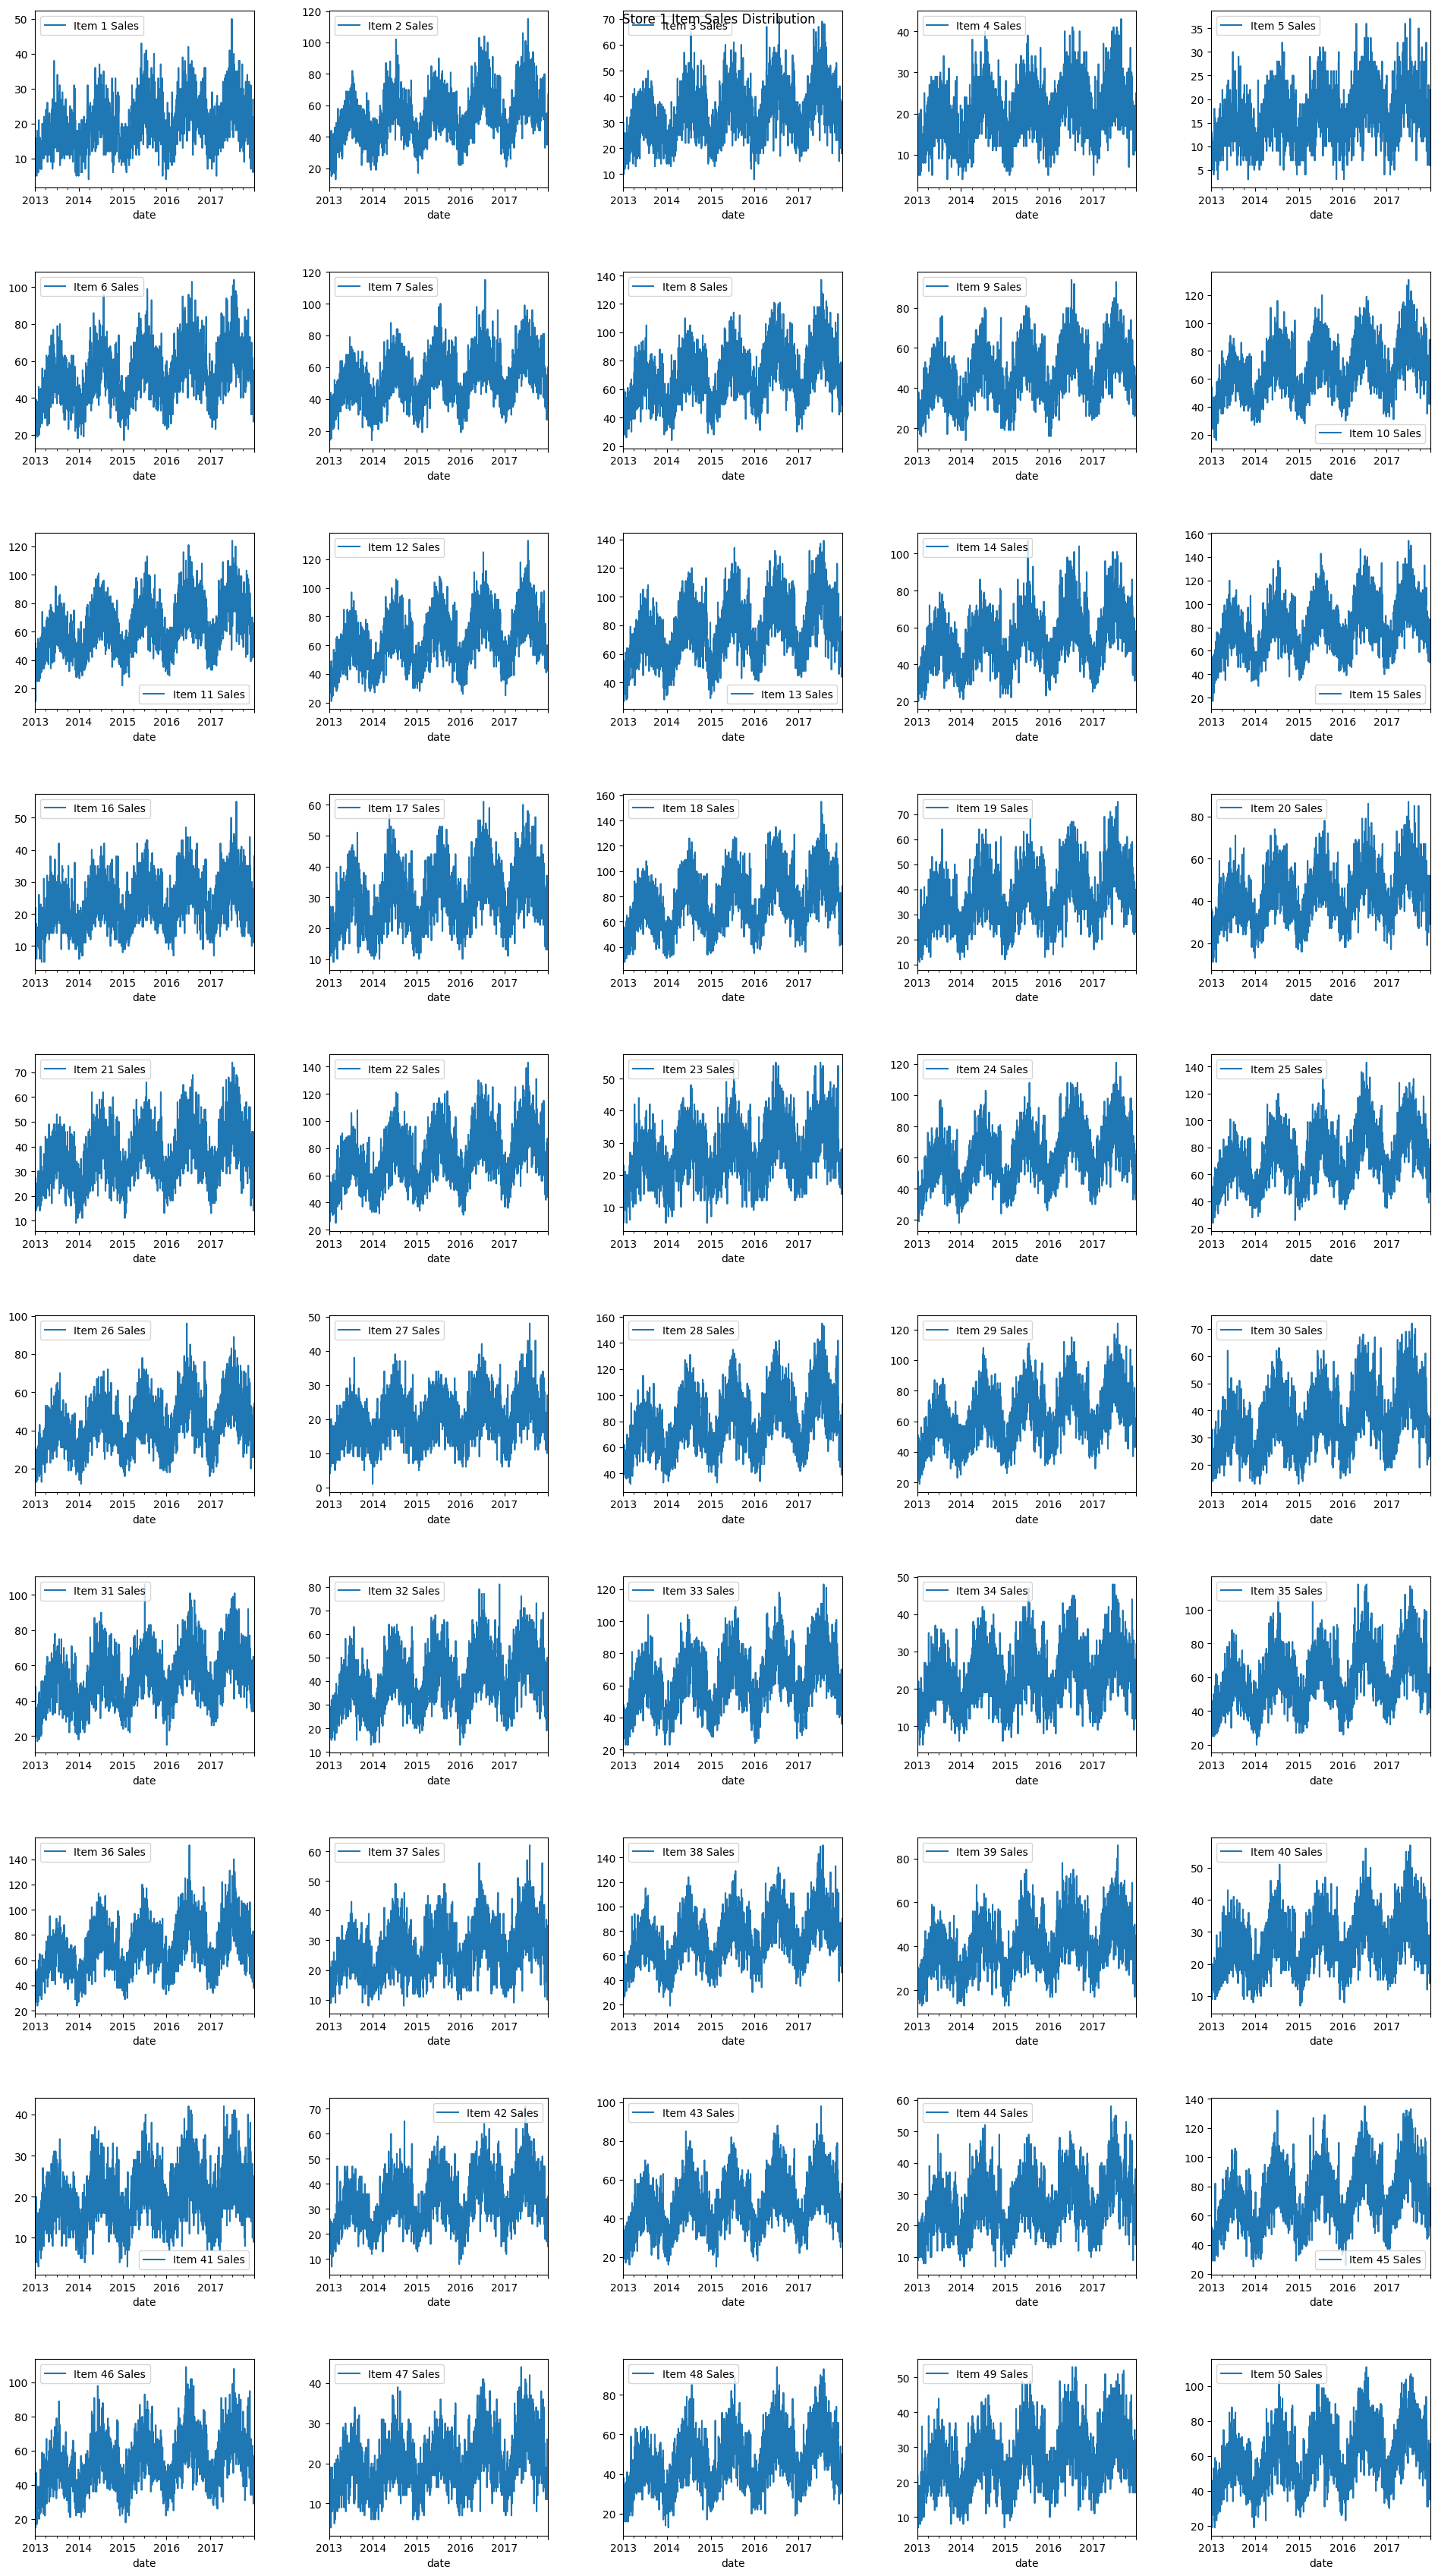

In [10]:
store = 1
sub = train[train.store == store].set_index("date")

fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 6 and i<11:
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 11 and i<16:
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 16 and i<21:
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 21 and i<26:
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 26 and i<31:
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 31 and i<36:
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 36 and i<41:
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 41 and i<46:
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 46 and i<51:
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales")
plt.tight_layout(pad=4.5)
plt.suptitle("Store 1 Item Sales Distribution");


# Hypothesis Testing

#### Conducting Shapiro-Wilk, Levene, T-Test/Welch Test, and Mann-Whitney U tests to compare pairs of stores and items, testing for normality, homogeneity, and differences in distributions.

##### 1. Normality Test: It uses the Shapiro-Wilk normality test to check if the distribution of data in both groups is normal. If the p-value from the test is less than 0.05, it considers the distribution as not normal (H1: Distribution is not Normal).

##### 2. Homogeneity Test: It uses Levene's test to check if the variances of the two groups are homogeneous. If the p-value from the test is less than 0.05, it considers the variances as heterogeneous (H1: Heterogeneous).

##### 3. Parametric or Non-Parametric T-Test: Depending on the results of the normality and homogeneity tests, it performs a parametric t-test or a non-parametric Mann-Whitney U test to compare the means of the two groups.


In [11]:
storesales = train.groupby(["date", "store"]).sales.sum().reset_index().set_index("date")

# T Test
def CompareTwoGroups(dataframe, group, target):

    import itertools
    from scipy.stats import shapiro
    import scipy.stats as stats

    # 1. Normality Test: Shapiro Test
    # 2. Homogeneity Test: Levene Test
    # 3. Parametric or Non-Parametric T Test: T-Test, Welch Test, Mann Whitney U

    # Create Combinations
    item_comb = list(itertools.combinations(dataframe[group].unique(), 2))

    AB = pd.DataFrame()
    for i in range(0, len(item_comb)):
        # Define Groups
        groupA = dataframe[dataframe[group] == item_comb[i][0]][target]
        groupB = dataframe[dataframe[group] == item_comb[i][1]][target]

        # Assumption: Normality
        ntA = shapiro(groupA)[1] < 0.05
        ntB = shapiro(groupB)[1] < 0.05
        # H0: Distribution is Normal! - False
        # H1: Distribution is not Normal! - True

        if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
            # Parametric Test
            # Assumption: Homogeneity of variances
            leveneTest = stats.levene(groupA, groupB)[1] < 0.05
            # H0: Homogeneity: False
            # H1: Heterogeneous: True
            if leveneTest == False:
                # Homogeneity
                ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
            else:
                # Heterogeneous
                ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
        else:
            # Non-Parametric Test
            ttest = stats.mannwhitneyu(groupA, groupB)[1]
            # H0: M1 = M2 - False
            # H1: M1 != M2 - True

        temp = pd.DataFrame({"Compare Two Groups":[ttest < 0.05],
                             "p-value":[ttest],
                             "GroupA_Mean":[groupA.mean()], "GroupB_Mean":[groupB.mean()],
                             "GroupA_Median":[groupA.median()], "GroupB_Median":[groupB.median()],
                             "GroupA_Count":[groupA.count()], "GroupB_Count":[groupB.count()]
                            }, index = [item_comb[i]])
        temp["Compare Two Groups"] = np.where(temp["Compare Two Groups"] == True, "Different Groups", "Similar Groups")
        temp["TestType"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")

        AB = pd.concat([AB, temp[["TestType", "Compare Two Groups", "p-value","GroupA_Median", "GroupB_Median","GroupA_Mean", "GroupB_Mean",
                                 "GroupA_Count", "GroupB_Count"]]])

    return AB




In [ ]:
# Comparing similarity between stores
CompareTwoGroups(storesales, group = "store", target = "sales")

,TestType,Compare Two Groups,p-value,GroupA_Median,GroupB_Median,GroupA_Mean,GroupB_Mean,GroupA_Count,GroupB_Count
"(1, 2)",Non-Parametric,Different Groups,1.142171e-261,2339.5,3310.5,2363.418949,3351.658269,1826,1826
"(1, 3)",Non-Parametric,Different Groups,9.986606e-135,2339.5,2937.5,2363.418949,2976.530120,1826,1826
"(1, 4)",Non-Parametric,Different Groups,4.089808e-62,2339.5,2708.0,2363.418949,2745.147317,1826,1826
"(1, 5)",Non-Parametric,Different Groups,1.482497e-80,2339.5,1970.5,2363.418949,1988.508215,1826,1826
"(1, 6)",Non-Parametric,Different Groups,1.322467e-81,2339.5,1963.0,2363.418949,1986.675794,1826,1826
"(1, 7)",Non-Parametric,Different Groups,4.984442e-167,2339.5,1796.5,2363.418949,1818.186747,1826,1826
"(1, 8)",Non-Parametric,Different Groups,2.806842e-213,2339.5,3174.5,2363.418949,3207.102410,1826,1826
"(1, 9)",Non-Parametric,Different Groups,6.988553e-64,2339.5,2719.5,2363.418949,2752.451260,1826,1826
"(1, 10)",Non-Parametric,Different Groups,7.007060e-121,2339.5,2899.0,2363.418949,2935.464403,1826,1826
"(2, 3)",Non-Parametric,Different Groups,1.634782e-40,3310.5,2937.5,3351.658269,2976.530120,1826,1826


In [12]:
# Comparing similarity between items
itemsales = train.groupby(["date", "item"]).sales.sum().reset_index().set_index("date")
ctg_is = CompareTwoGroups(itemsales, group = "item", target = "sales")
ctg_is[ctg_is["Compare Two Groups"] == "Similar Groups"]

,TestType,Compare Two Groups,p-value,GroupA_Median,GroupB_Median,GroupA_Mean,GroupB_Mean,GroupA_Count,GroupB_Count
"(1, 4)",Non-Parametric,Similar Groups,0.842383,218.0,218.0,219.815991,220.102410,1826,1826
"(1, 27)",Non-Parametric,Similar Groups,0.746252,218.0,218.0,219.815991,220.497262,1826,1826
"(1, 41)",Non-Parametric,Similar Groups,0.961622,218.0,218.0,219.815991,220.021358,1826,1826
"(1, 47)",Non-Parametric,Similar Groups,0.946145,218.0,217.0,219.815991,220.033406,1826,1826
"(2, 6)",Non-Parametric,Similar Groups,0.899452,578.0,578.5,585.741512,585.038883,1826,1826
...,...,...,...,...,...,...,...,...,...
"(40, 44)",Non-Parametric,Similar Groups,0.489586,289.0,291.0,292.493976,293.981928,1826,1826
"(40, 49)",Non-Parametric,Similar Groups,0.769478,289.0,289.0,292.493976,293.353231,1826,1826
"(41, 47)",Non-Parametric,Similar Groups,0.993689,218.0,217.0,220.021358,220.033406,1826,1826
"(43, 48)",Non-Parametric,Similar Groups,0.902335,508.5,506.0,512.943593,513.528478,1826,1826


# Feature Engineering
## Key time series features were engineered to enhance model performance:

### 1) Time-Related Features:
##### These are features that extract information from time data, making them particularly useful in time series forecasting or any model where the time aspect is relevant. Common time-related features include: different granularities of time, such as month, day, quarter, whether it's a weekend, and the season of the year.

### 2) Hypothesis Testing:
##### Similar Stores and Items

### 3) Lagged features:
##### Values from previous time steps. When you're tasked with predicting future values, such as the demand for items in a store for the next 90 days, creating lag features means you will use the values from the previous days (at least 91 days back, in this case) to predict the future.

### 4) Moving Average Features:
##### To smooth out short-term fluctuations and highlight longer-term trends or cycles. The moving average is calculated by taking the average of a specific number of time periods, like days or weeks, and then rolling that average forward with each new period.

### 6) Exponentially Weighted Mean Features:
##### To give more significance to recent observations while considering the older ones.


In [13]:
# 1. Time Related Features
#####################################################
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.isocalendar().week.astype('int64')
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df["quarter"] = df.date.dt.quarter
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)
    df['is_year_start'] = df.date.dt.is_year_start.astype(int)
    df['is_year_end'] = df.date.dt.is_year_end.astype(int)
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    return df
df = create_date_features(df)

In [15]:
# Rolling Summary Stats Features
#####################################################
for i in [91, 98, 105, 112, 119, 126, 186, 200, 210, 250, 300, 365, 546, 700]:
    df["sales_roll_mean_"+str(i)]=df.groupby(["store", "item"]).sales.rolling(i).mean().shift(1).values


In [16]:
# 2. Hypothesis Testing: Similarity
#####################################################

# Store Based
storesales = train.groupby(["date", "store"]).sales.sum().reset_index()
ctg_ss = CompareTwoGroups(storesales, group="store", target="sales")
del storesales

df["StoreSalesSimilarity"] = np.where(df.store.isin([3,10]), 1, 0)
df["StoreSalesSimilarity"] = np.where(df.store.isin([4,9]), 2, df["StoreSalesSimilarity"])
df["StoreSalesSimilarity"] = np.where(df.store.isin([5,6]), 3, df["StoreSalesSimilarity"])


In [17]:
# Item Based

itemsales = train.groupby(["date", "item"]).sales.sum().reset_index()
ctg_is = CompareTwoGroups(itemsales, group = "item", target = "sales")
del itemsales

df["ItemSalesSimilarity"] = np.where(df.item.isin([1,4,27,41,47]), 1, 0)
df["ItemSalesSimilarity"] = np.where(df.item.isin([2,6,7,14,31,46]), 2, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([3,42]), 3, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([8,36]), 4, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([9,43,48]), 5, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([11,12,29,33]), 6, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([13,18]), 7, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([15,28]), 8, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([16,34]), 9, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([19,21,30]), 10, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([20,26]), 11, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([22,25,38,45]), 12, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([23,37,40,44,49]), 13, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([24,35,50]), 14, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([32,39]), 15, df["ItemSalesSimilarity"])


In [18]:
# 3. Lag/Shifted Features
#####################################################

# test.groupby(["store", "item"]).date.count()

df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

def lag_features(dataframe, lags, groups = ["store", "item"], target = "sales", prefix = ''):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe[prefix + str(lag)] = dataframe.groupby(groups)[target].transform(
            lambda x: x.shift(lag))
    return dataframe

df = lag_features(df, lags = [91, 92,93,94,95,96, 97, 98, 100, 105, 112, 119, 126, 150,
                              182,200,220, 250, 300, 350, 355, 360,361,362,363, 364,
                              365, 370, 375,380, 546, 600, 650, 680, 690, 700, 710, 728,
                              730, 800, 900, 950, 990, 1000, 1050, 1090, 1095],
                  groups = ["store", "item"], target = 'sales', prefix = 'sales_lag_')

def drop_cor(dataframe, name, index):
    ind = dataframe[dataframe.columns[dataframe.columns.str.contains(name)].tolist()+["sales"]].corr().sales.sort_values(ascending = False).index[1:index]
    ind = dataframe.drop(ind, axis = 1).columns[dataframe.drop(ind, axis = 1).columns.str.contains(name)]
    dataframe.drop(ind, axis = 1, inplace = True)

drop_cor(df, "sales_lag", 16)


In [19]:
# 4. Last i. Months
#####################################################
df["monthyear"] = df.date.dt.to_period('M')

# Store-Item Based
for i in [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]:
    last_months = df.groupby(["store", "item", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['store', 'item', 'monthyear', 'last_'+str(i)+'months_sales_sum',
                           'last_'+str(i)+'months_sales_mean', 'last_'+str(i)+'months_sales_std',
                           'last_'+str(i)+'months_sales_min', 'last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how   = "left", on = ["store", "item", "monthyear"])
del last_months, i

drop_cor(df, "last_", 15)

# Store Based


for i in [3, 6, 9, 12]:
    last_months = df.groupby(["store", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['store', 'monthyear', 'store_last_'+str(i)+'months_sales_sum',
                           'store_last_'+str(i)+'months_sales_mean', 'store_last_'+str(i)+'months_sales_std',
                           'store_last_'+str(i)+'months_sales_min', 'store_last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how = "left", on = ["store", "monthyear"])
del last_months, i

# Item Based
for i in [3, 6, 9, 12]:
    last_months = df.groupby(["item", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['item', 'monthyear', 'item_last_'+str(i)+'months_sales_sum',
                           'item_last_'+str(i)+'months_sales_mean', 'item_last_'+str(i)+'months_sales_std',
                           'item_last_'+str(i)+'months_sales_min', 'item_last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how = "left", on = ["item", "monthyear"])
del last_months, i

# Similarity Based


for i in [3, 6, 9, 12]:
    last_months = df.groupby(["StoreSalesSimilarity", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['StoreSalesSimilarity', 'monthyear', 'storesim_last_'+str(i)+'months_sales_sum',
                           'storesim_last_'+str(i)+'months_sales_mean', 'storesim_last_'+str(i)+'months_sales_std',
                           'storesim_last_'+str(i)+'months_sales_min', 'storesim_last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how = "left", on = ["StoreSalesSimilarity", "monthyear"])
del last_months, i


for i in [3, 6, 9, 12]:
    last_months = df.groupby(["ItemSalesSimilarity", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['ItemSalesSimilarity', 'monthyear', 'itemsim_last_'+str(i)+'months_sales_sum',
                           'itemsim_last_'+str(i)+'months_sales_mean', 'itemsim_last_'+str(i)+'months_sales_std',
                           'itemsim_last_'+str(i)+'months_sales_min', 'itemsim_last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how = "left", on = ["ItemSalesSimilarity", "monthyear"])
del last_months, i

df.drop("monthyear", axis = 1, inplace = True)



In [20]:

# 5. Last i. day of week
#####################################################
df.sort_values(["store", "item", "day_of_week", "date"], inplace = True)

df = lag_features(df, lags = np.arange(12,41, 1).tolist()+[91, 92, 95, 98, 99, 100, 105, 112, 119, 126, 133, 140, 200, 205, 210, 215, 220, 250],
                  groups = ["store", "item", "day_of_week"], target = 'sales', prefix = 'dayofweek_sales_lag_')

df[df.columns[df.columns.str.contains("dayofweek_sales_lag_")].tolist()+["sales"]].corr().sales.sort_values(ascending = False)

drop_cor(df, "dayofweek_sales_lag_", 16)

df.sort_values(["store", "item", "date"], inplace = True)



In [21]:
#####################################################
# Exponentially Weighted Mean Features
#####################################################
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

# Day of year
df.sort_values(["day_of_year", "store", "item"], inplace = True)
df = lag_features(df, lags = [1,2,3,4],
                  groups = ["day_of_year", "store", "item"], target = 'sales', prefix = 'dayofyear_sales_lag_')


# pd.cut
clus = df.groupby(["store"]).sales.mean().reset_index()
clus["store_cluster"] =  pd.cut(clus.sales, bins = 4, labels = range(1,5))
clus.drop("sales", axis = 1, inplace = True)
df = pd.merge(df, clus, how = "left")
clus = df.groupby(["item"]).sales.mean().reset_index()
clus["item_cluster"] =  pd.cut(clus.sales, bins = 5, labels = range(1,6))
clus.drop("sales", axis = 1, inplace = True)
df = pd.merge(df, clus, how = "left")
del clus

df.shape

(913000, 210)

In [22]:
# Dataframe must be sorted by date because of Time Series Split
df = df.sort_values("date").reset_index(drop = True)

# Train Validation Split
# Validation set includes 3 months (Oct. Nov. Dec. 2017)
train = df.loc[(df["date"] < "2016-10-01"), :]
val = df.loc[(df["date"] >= "2016-10-01") & (df["date"] < "2017-01-01"), :]


cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((684500,), (684500, 207), (46000,), (46000, 207))

In [26]:
X_train

,store,item,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,sales_roll_mean_91,sales_roll_mean_98,sales_roll_mean_105,sales_roll_mean_112,sales_roll_mean_119,sales_roll_mean_126,sales_roll_mean_186,sales_roll_mean_200,sales_roll_mean_210,sales_roll_mean_250,sales_roll_mean_300,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_700,StoreSalesSimilarity,ItemSalesSimilarity,sales_lag_350,sales_lag_355,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_370,sales_lag_380,sales_lag_700,sales_lag_728,sales_lag_730,sales_lag_1050,sales_lag_1090,last_3months_sales_sum,last_3months_sales_mean,last_3months_sales_std,last_3months_sales_min,last_3months_sales_max,last_9months_sales_sum,last_9months_sales_mean,last_9months_sales_min,last_9months_sales_max,last_12months_sales_sum,last_12months_sales_mean,last_12months_sales_std,last_12months_sales_min,last_12months_sales_max,store_last_3months_sales_sum,store_last_3months_sales_mean,store_last_3months_sales_std,store_last_3months_sales_min,store_last_3months_sales_max,store_last_6months_sales_sum,store_last_6months_sales_mean,store_last_6months_sales_std,store_last_6months_sales_min,store_last_6months_sales_max,store_last_9months_sales_sum,store_last_9months_sales_mean,store_last_9months_sales_std,store_last_9months_sales_min,store_last_9months_sales_max,store_last_12months_sales_sum,store_last_12months_sales_mean,store_last_12months_sales_std,store_last_12months_sales_min,store_last_12months_sales_max,item_last_3months_sales_sum,item_last_3months_sales_mean,item_last_3months_sales_std,item_last_3months_sales_min,item_last_3months_sales_max,item_last_6months_sales_sum,item_last_6months_sales_mean,item_last_6months_sales_std,item_last_6months_sales_min,item_last_6months_sales_max,item_last_9months_sales_sum,item_last_9months_sales_mean,item_last_9months_sales_std,item_last_9months_sales_min,item_last_9months_sales_max,item_last_12months_sales_sum,item_last_12months_sales_mean,item_last_12months_sales_std,item_last_12months_sales_min,item_last_12months_sales_max,storesim_last_3months_sales_sum,storesim_last_3months_sales_mean,storesim_last_3months_sales_std,storesim_last_3months_sales_min,storesim_last_3months_sales_max,storesim_last_6months_sales_sum,storesim_last_6months_sales_mean,storesim_last_6months_sales_std,storesim_last_6months_sales_min,storesim_last_6months_sales_max,storesim_last_9months_sales_sum,storesim_last_9months_sales_mean,storesim_last_9months_sales_std,storesim_last_9months_sales_min,storesim_last_9months_sales_max,storesim_last_12months_sales_sum,storesim_last_12months_sales_mean,storesim_last_12months_sales_std,storesim_last_12months_sales_min,storesim_last_12months_sales_max,itemsim_last_3months_sales_sum,itemsim_last_3months_sales_mean,itemsim_last_3months_sales_std,itemsim_last_3months_sales_min,itemsim_last_3months_sales_max,itemsim_last_6months_sales_sum,itemsim_last_6months_sales_mean,itemsim_last_6months_sales_std,itemsim_last_6months_sales_min,itemsim_last_6months_sales_max,itemsim_last_9months_sales_sum,itemsim_last_9months_sales_mean,itemsim_last_9months_sales_std,itemsim_last_9months_sales_min,itemsim_last_9months_sales_max,itemsim_last_12months_sales_sum,itemsim_last_12months_sales_mean,itemsim_last_12months_sales_std,itemsim_last_12months_sales_min,itemsim_last_12months_sales_max,dayofweek_sales_lag_12,dayofweek_sales_lag_13,dayofweek_sales_lag_40,dayofweek_sales_lag_92,dayofweek_sales_lag_95,dayofweek_sales_lag_98,dayofweek_sales_lag_99,dayofweek_sales_lag_100,dayofweek_sales_lag_105,dayofweek_sales_lag_112,dayofweek_sales_lag_200,dayofweek_sales_lag_205,dayofweek_sales_lag_210,dayofweek_sales_lag_215,dayofweek_sales_lag_220,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_e

In [ ]:
# train.head()

In [ ]:
# val.head()

In [ ]:
# df.head()

In [ ]:
# print(df.columns)

In [ ]:
# df.id.head()

## Evaluation

##### Submissions are evaluated on SMAPE between forecasts and actual values. We define SMAPE = 0 when the actual and predicted values are both 0.

In [23]:
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(y_true, y_pred):
    smape_val = smape(y_true, y_pred)
    return 'SMAPE', smape_val, False

# Model Development:
### Two sequential LightGBM models were built with an emphasis on feature importance and optimization.


## **First Model**
### (Using Default Parameters)

In [27]:
first_model = lgb.LGBMRegressor(random_state=384).fit(X_train, Y_train,
                                                      eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])
print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.248899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37165
[LightGBM] [Info] Number of data points in the train set: 684500, number of used features: 201
[LightGBM] [Info] Start training from score 50.478124
TRAIN SMAPE: 13.217611659884927
VALID SMAPE: 12.914455534893131


## Exploratory Analysis of Feature Importance
#### Analyze and visualize the most important features that influence the predictions of the first_model.

In [28]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns

    # LGBM API
    #gain = model.feature_importance('gain')
    #feat_imp = pd.DataFrame({'feature': model.feature_name(),
    #                         'split': model.feature_importance('split'),
    #                         'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)

    # SKLEARN API
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=50)

                              feature  split       gain
38                      sales_lag_364    344  44.413748
141            dayofweek_sales_lag_12    127  18.040628
206                      item_cluster    153   9.519118
32                      sales_lag_350    142   6.076415
156        sales_ewm_alpha_095_lag_91     11   4.437774
57           last_12months_sales_mean    150   2.826751
198        sales_ewm_alpha_05_lag_365     58   1.516973
157        sales_ewm_alpha_095_lag_98     16   1.300363
15                             season     49   1.280421
6                         day_of_week    226   1.200488
205                     store_cluster    115   1.109453
189        sales_ewm_alpha_07_lag_365     22   0.798084
24                sales_roll_mean_210     25   0.622156
142            dayofweek_sales_lag_13     14   0.558162
200        sales_ewm_alpha_05_lag_728     33   0.525721
165         sales_ewm_alpha_09_lag_91     10   0.475174
118  storesim_last_12months_sales_std     22   0

In [ ]:
feature_imp_df.shape, feature_imp_df[feature_imp_df.gain > 0].shape, feature_imp_df[feature_imp_df.gain > 0.57].shape

((207, 3), (168, 3), (13, 3))

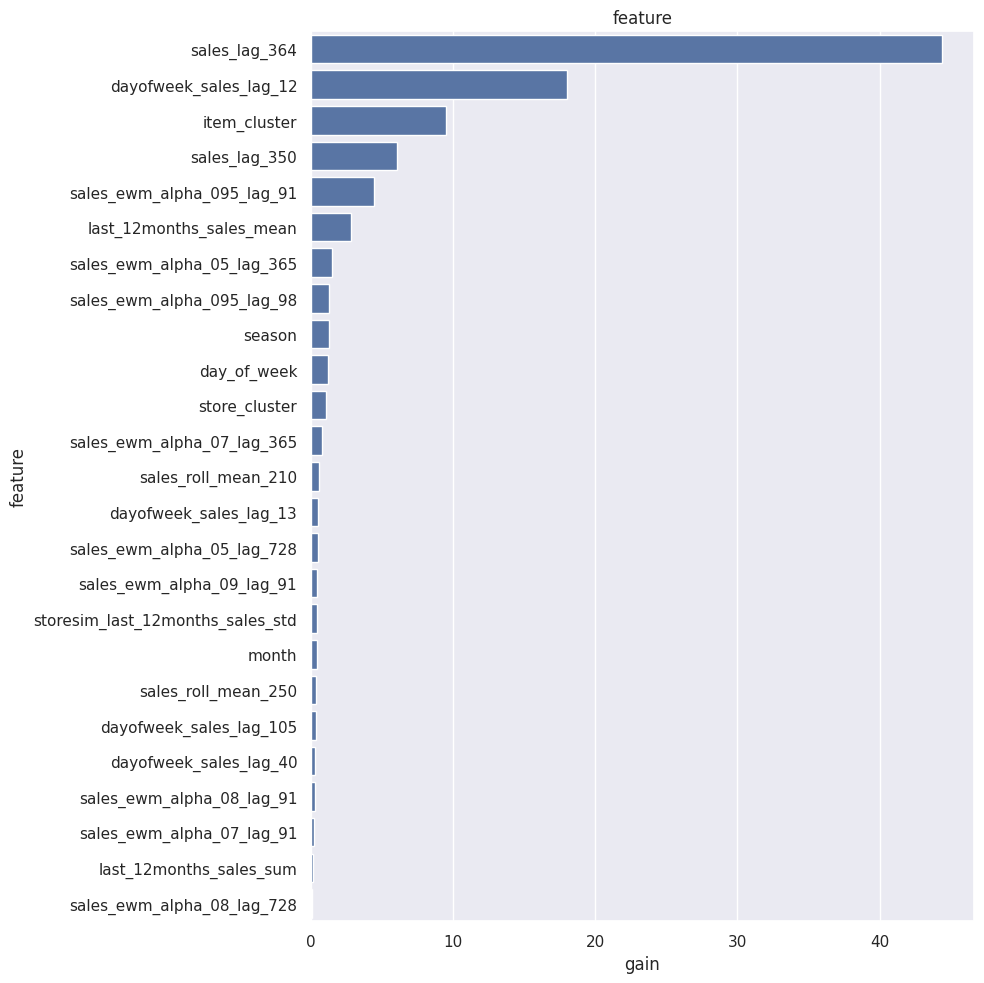

In [29]:
plot_lgb_importances(first_model, plot=True, num=30)


### **SHAP** (SHapley Additive exPlanations)
#### The "Shap" library, is commonly used for understanding the feature importance and the impact of features on model predictions. We generate SHAP values for the first_model to gain insights into the model's behavior.

In [ ]:
explainer = shap.Explainer(first_model)
shap_values_train = explainer(X_train)
shap_values_valid = explainer(X_val)

len(shap_values_train), len(shap_values_valid)

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values_train, max_display=30)

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values_valid, max_display=30)

In [ ]:
shap.plots.bar(shap_values_train, max_display=30)

### Error Analysis

In [ ]:
error = pd.DataFrame({
    "date":val.date,
    "store":X_val.store,
    "item":X_val.item,
    "actual":Y_val,
    "pred":first_model.predict(X_val)
}).reset_index(drop = True)

error["error"] = np.abs(error.actual-error.pred)

error.sort_values("error", ascending=False).head(20)

In [ ]:
error[["actual", "pred", "error"]].describe([0.7, 0.8, 0.9, 0.95, 0.99]).T

In [ ]:
shap.plots.waterfall(shap_values_valid[30125])

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values_valid[30125])

In [ ]:
shap.plots.waterfall(shap_values_valid[20669])


In [ ]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values_valid[20669])

In [ ]:
shap.plots.waterfall(shap_values_valid[9009])


In [ ]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values_valid[9009])

In [ ]:
# Mean Absolute Error
error.groupby(["store", "item"]).error.mean().sort_values(ascending = False)

In [ ]:
# Mean Absolute Error
error.groupby(["store"]).error.mean().sort_values(ascending = False)

In [ ]:
# Mean Absolute Error
error.groupby(["item"]).error.mean().sort_values(ascending = False)

#### Store 1 Validation Set: Actual & Pred

In [ ]:
# Store 1 Actual - Pred
sub = error[error.store == 1].set_index("date")
fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].actual.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[0, i - 1], legend=True, label="Item " + str(i) + " Pred", linestyle = "dashed")
    if i >= 6 and i<11:
        sub[sub.item == i].actual.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[1, i - 6], legend=True, label="Item " + str(i) + " Pred",  linestyle="dashed")
    if i >= 11 and i<16:
        sub[sub.item == i].actual.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[2, i - 11], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 16 and i<21:
        sub[sub.item == i].actual.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[3, i - 16], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 21 and i<26:
        sub[sub.item == i].actual.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[4, i - 21], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 26 and i<31:
        sub[sub.item == i].actual.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[5, i - 26], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 31 and i<36:
        sub[sub.item == i].actual.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[6, i - 31], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 36 and i<41:
        sub[sub.item == i].actual.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[7, i - 36], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 41 and i<46:
        sub[sub.item == i].actual.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[8, i - 41], legend=True, label="Item " + str(i) + " Pred",linestyle="dashed")
    if i >= 46 and i<51:
        sub[sub.item == i].actual.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[9, i - 46], legend=True, label="Item " + str(i) + " Pred",linestyle="dashed")
plt.tight_layout(pad=4.5)
plt.suptitle("Store 1 Item Satış Dağılımı");
plt.show()

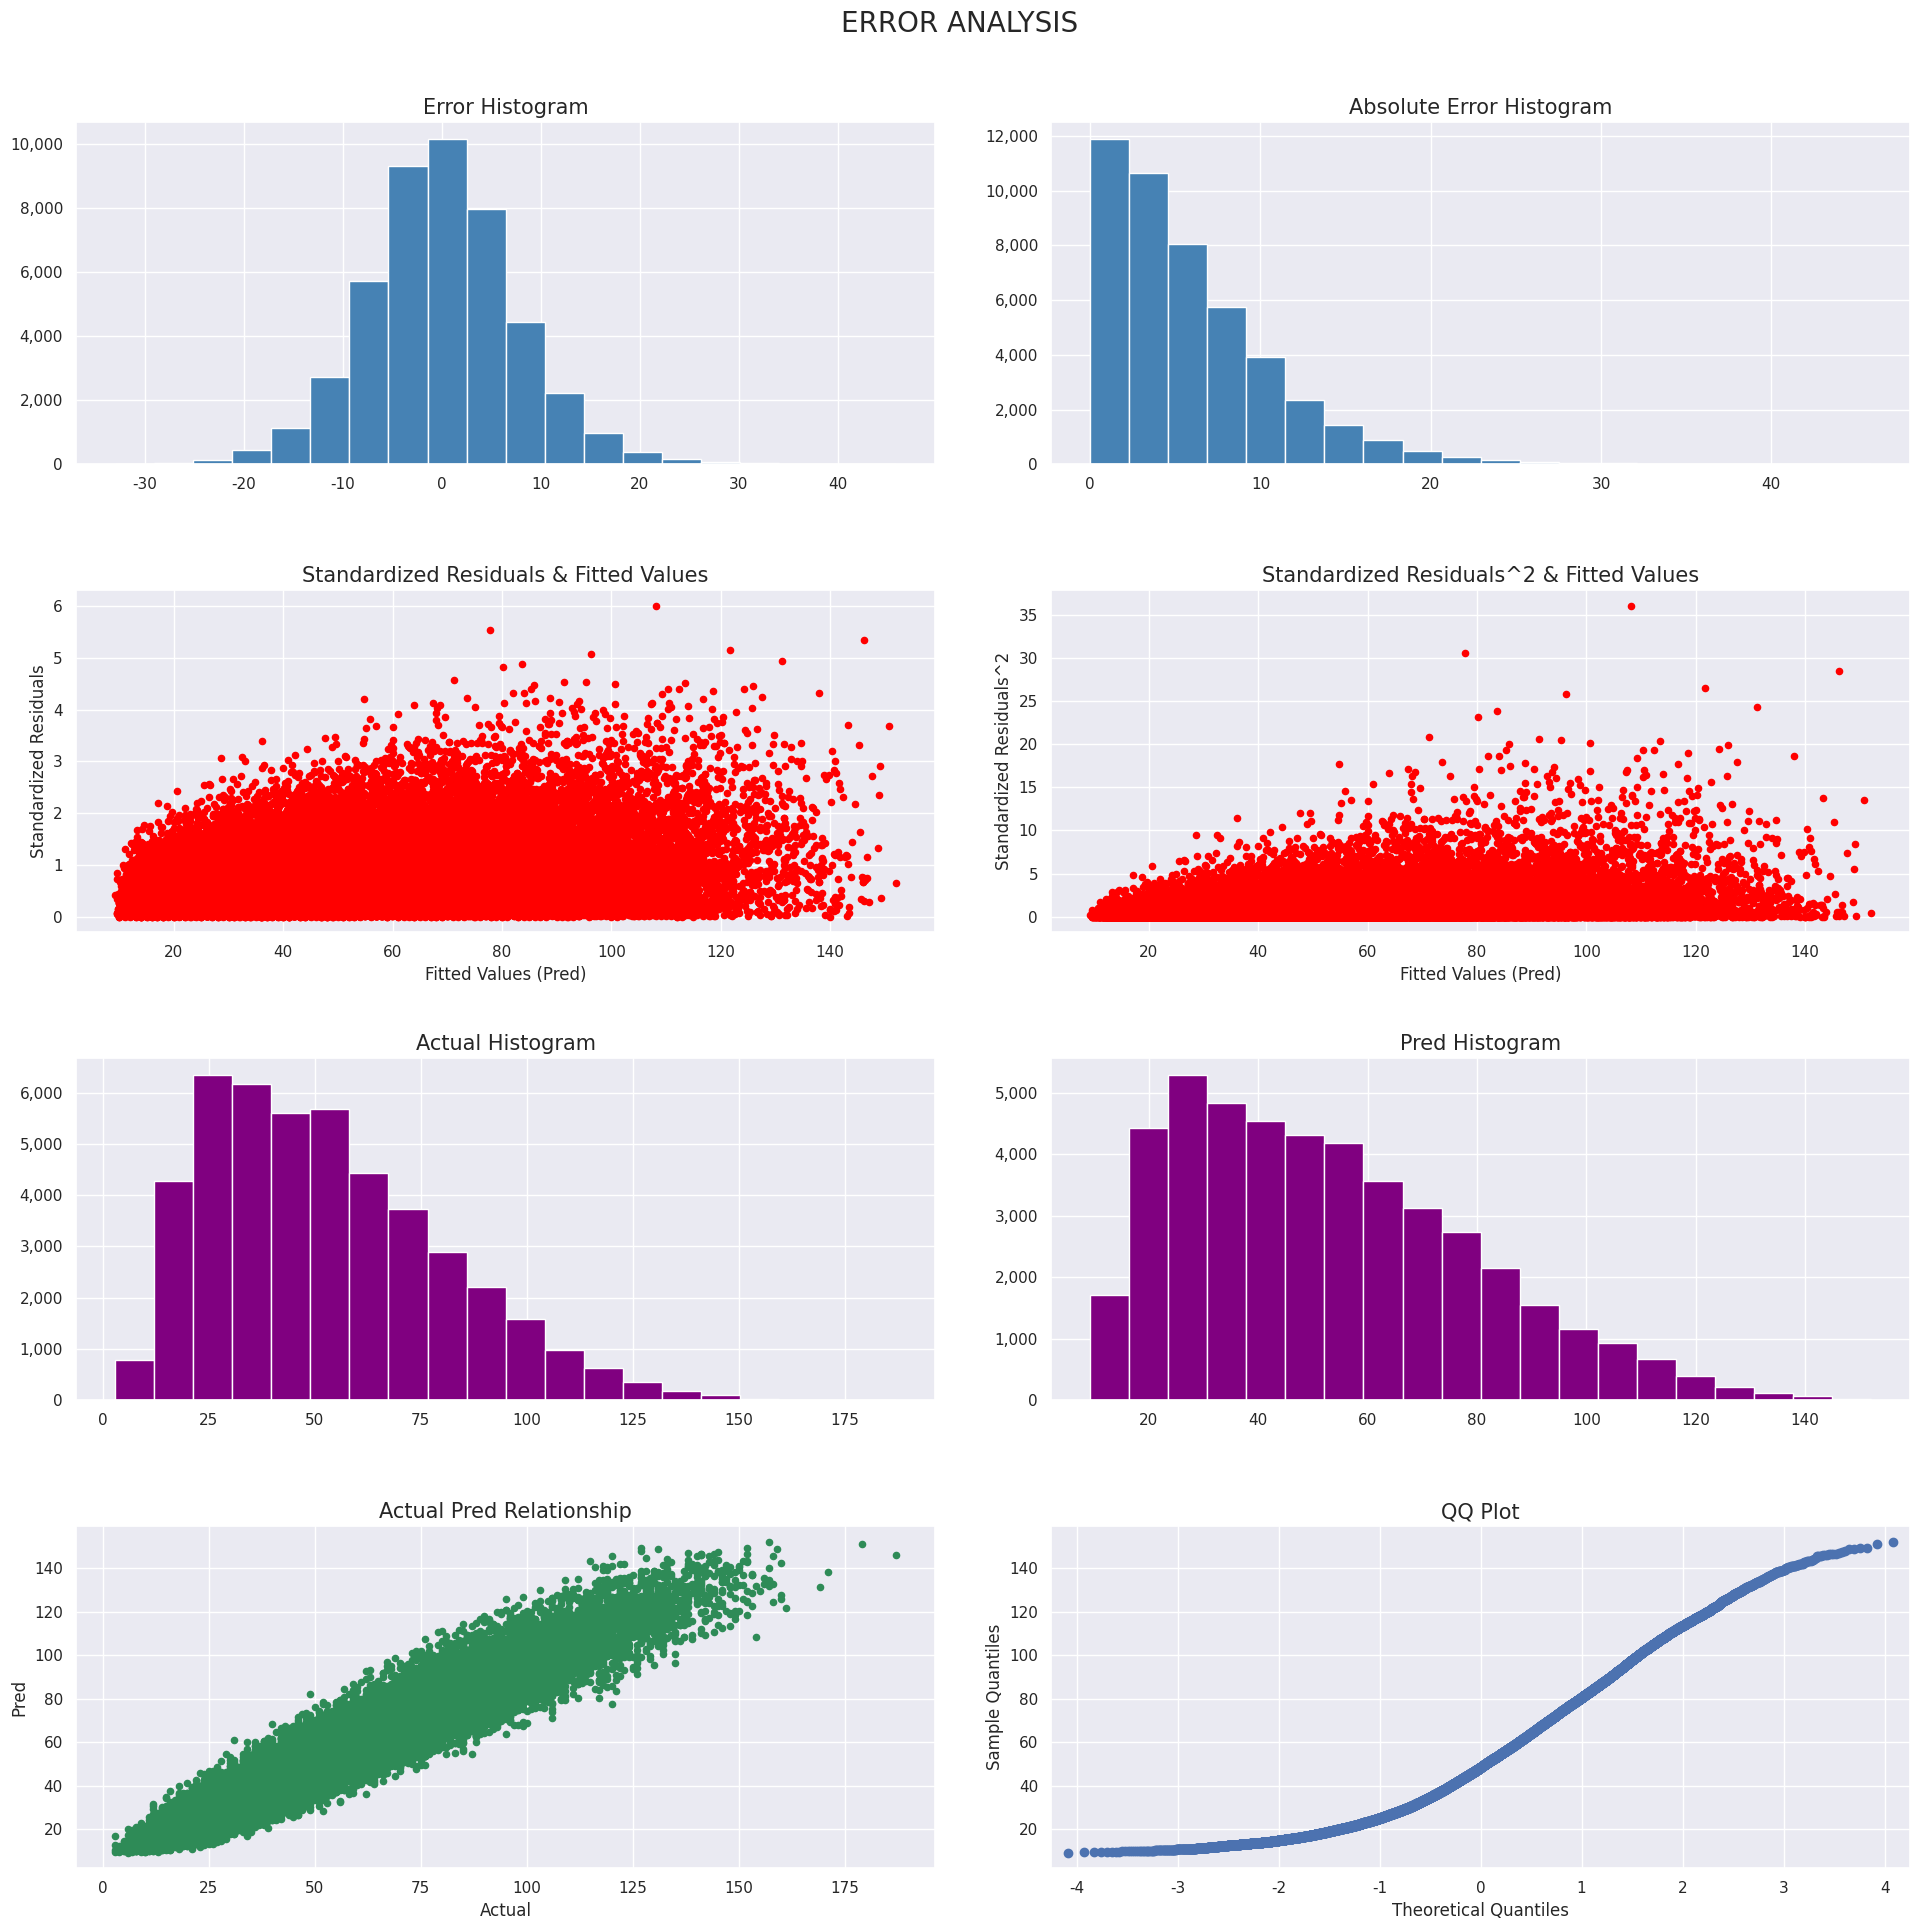

In [ ]:
fig, axes = plt.subplots(4, 2, figsize = (20,20))
for axi in axes.flat:
    axi.ticklabel_format(style="sci", axis="y", scilimits=(0,10))
    axi.ticklabel_format(style="sci", axis="x", scilimits=(0,10))
    axi.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    axi.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

(error.actual-error.pred).hist(ax = axes[0, 0], color = "steelblue", bins = 20)
error.error.hist(ax = axes[0,1], color = "steelblue", bins = 20)
sr = error.copy()
sr["StandardizedR"] = (sr.error / (sr.actual-sr.pred).std())
sr["StandardizedR2"] = ((sr.error / (sr.actual-sr.pred).std())**2)
sr.plot.scatter(x = "pred",y = "StandardizedR", color = "red", ax = axes[1,0])
sr.plot.scatter(x = "pred",y = "StandardizedR2", color = "red", ax = axes[1,1])
error.actual.hist(ax = axes[2, 0], color = "purple", bins = 20)
error.pred.hist(ax = axes[2, 1], color = "purple", bins = 20)
error.plot.scatter(x = "actual",y = "pred", color = "seagreen", ax = axes[3,0]);
# QQ Plot
import statsmodels.api as sm
import pylab
sm.qqplot(sr.pred, ax = axes[3,1], c = "seagreen")
plt.suptitle("ERROR ANALYSIS", fontsize = 20)
axes[0,0].set_title("Error Histogram", fontsize = 15)
axes[0,1].set_title("Absolute Error Histogram", fontsize = 15)
axes[1,0].set_title("Standardized Residuals & Fitted Values", fontsize = 15)
axes[1,1].set_title("Standardized Residuals^2 & Fitted Values", fontsize = 15)
axes[2,0].set_title("Actual Histogram", fontsize = 15)
axes[2,1].set_title("Pred Histogram", fontsize = 15);
axes[3,0].set_title("Actual Pred Relationship", fontsize = 15);
axes[3,1].set_title("QQ Plot", fontsize = 15);
axes[1,0].set_xlabel("Fitted Values (Pred)", fontsize = 12)
axes[1,1].set_xlabel("Fitted Values (Pred)", fontsize = 12)
axes[3,0].set_xlabel("Actual", fontsize = 12)
axes[1,0].set_ylabel("Standardized Residuals", fontsize = 12)
axes[1,1].set_ylabel("Standardized Residuals^2", fontsize = 12)
axes[3,0].set_ylabel("Pred", fontsize = 12)
fig.tight_layout(pad=3.0)
plt.savefig("errors.png")
plt.show()

## **Second Model**
### Default Parameters & Feature Selection with LGBM Feature Importance

In [ ]:
# First model feature importance
cols = feature_imp_df[feature_imp_df.gain > 0.015].feature.tolist()
print("Independent Variables:", len(cols))

second_model = lgb.LGBMRegressor(random_state=384).fit(
    X_train[cols], Y_train,
    eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, second_model.predict(X_train[cols])))
print("VALID SMAPE:", smape(Y_val, second_model.predict(X_val[cols])))

Independent Variables: 67
TRAIN SMAPE: 13.228657712526589
VALID SMAPE: 12.883759741169996


# **Hyperparameter Tuning**
### 2 Step tuning process

#### **1st Optimization:** Finding other parameters when the number of iterations is constant (GridSearchedCV, RandomSearchedCV etc.)
#### **2nd Optimization:** Finding best iteration number by using early stopping round



# First Optimization (RandomizedSearchCV):

### Employed RandomizedSearchCV to search for the optimal combination of hyperparameters within a predefined grid, reducing the hyperparameter space randomly to find an efficient solution.

In [ ]:
# #### First Optimization: Hyperparameter Tuning with Random Searched
# lgbm_params = {

#     "num_leaves":[20,31], # Default 31
#     "max_depth":[-1, 20, 30], # Default -1
#     "learning_rate":[0.1, 0.05], # Default 0.1
#     "n_estimators":[10000,15000], # Default 100
#     "min_split_gain":[0.0, 2,5], # Default 0
#     "min_child_samples":[10, 20, 30], # Default 20
#     "colsample_bytree":[0.5, 0.8, 1.0], # Default 1
#     "reg_alpha":[0.0, 0.5, 1], # Default 0
#     "reg_lambda":[0.0, 0.5, 1] # Default 0
# }

# model = lgb.LGBMRegressor(random_state=384)



In [ ]:
# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
# from sklearn.metrics import make_scorer

# tscv = TimeSeriesSplit(n_splits=3)

# rsearch = RandomizedSearchCV(model, lgbm_params, random_state=384,
#                              cv=tscv, scoring=make_scorer(smape),
#                              verbose = True, n_jobs = -1).fit(
#     X_train[cols], Y_train
# )

# print(rsearch.best_params_)

In [ ]:
# # **When Random Searched CV finished running, it gives us best parameters in sample paramater space. Then, we should train a new model with best parameters and evaluate model performance.**

# model_tuned = lgb.LGBMRegressor(**rsearch.best_params_, random_state=384).fit(X_train[cols], Y_train)

# print("TRAIN SMAPE:", smape(Y_train, model_tuned.predict(X_train[cols])))

# print("VALID SMAPE:", smape(Y_val, model_tuned.predict(X_val[cols])))

# Second Optimization (Early Stopping):
### Determined the best iteration number using early stopping rounds to prevent overfitting, incorporating the optimized hyperparameters from the first stage.

In [ ]:
# Best Params: {'reg_lambda': 0.0, 'reg_alpha': 1, 'num_leaves': 20, 'n_estimators': 10000, 'min_split_gain': 0.0, 'min_child_samples': 20, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
# model_tuned2 = lgb.LGBMRegressor(**rsearch.best_params_, random_state=384, metric = "custom")


model_tuned2 = lgb.LGBMRegressor(reg_lambda=0.0, reg_alpha=1, num_leaves=20, n_estimators=10000, min_split_gain=0.0, min_child_samples=20, max_depth=20, learning_rate=0.1, colsample_bytree=1.0, random_state=384, metric="custom")


model_tuned2.fit(
    X_train[cols], Y_train,
    eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)],
    eval_set = [(X_train[cols], Y_train), (X_val[cols], Y_val)],
    eval_names = ["Train", "Valid"],
    early_stopping_rounds= 1000, verbose = 500
)
print("Best Iteration:", model_tuned2.booster_.best_iteration)

[500]	Train's SMAPE: 12.9014	Valid's SMAPE: 12.6911
[1000]	Train's SMAPE: 12.7437	Valid's SMAPE: 12.6482
[1500]	Train's SMAPE: 12.6248	Valid's SMAPE: 12.6378
[2000]	Train's SMAPE: 12.5186	Valid's SMAPE: 12.64
[2500]	Train's SMAPE: 12.418	Valid's SMAPE: 12.6485
Best Iteration: 1665


# **Final Model**

In [ ]:
df.sort_values(["store", "item", "date"], inplace = True)

train_final = df.loc[(df["date"] < "2017-01-01"), :]
test_final = df.loc[(df["date"] >= "2017-01-01"), :]

X_train_final = train_final[cols]
Y_train_final = train_final.sales
X_test_final = test_final[cols]


#final_model = lgb.LGBMRegressor(**rsearch.best_params_, random_state=384, metric = "custom") # Tuned parameters
# Best Params: {'reg_lambda': 0.0, 'reg_alpha': 1, 'num_leaves': 20, 'n_estimators': 10000, 'min_split_gain': 0.0, 'min_child_samples': 20, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
final_model = lgb.LGBMRegressor(reg_lambda=0.0, reg_alpha=1, num_leaves=20, n_estimators=10000, min_split_gain=0.0, min_child_samples=20, max_depth=20, learning_rate=0.1, colsample_bytree=1.0, random_state=384, metric="custom")
final_model.set_params(n_estimators=model_tuned2.booster_.best_iteration)
final_model.fit(X_train_final[cols], Y_train_final,
                eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

LGBMRegressor(max_depth=20, metric='custom', n_estimators=1665, num_leaves=20,
              random_state=384, reg_alpha=1)

# Submission

In [ ]:
test_final.reset_index(drop=True, inplace=True)
test_final['id'] = test_final.index

In [ ]:
submission = pd.DataFrame({
    "id":test_final.id.astype(int),
    "sales":final_model.predict(X_test_final)
})
submission.to_csv("submission.csv", index = None)

In [ ]:
submission[["sales"]].describe([0.1, 0.75, 0.8, 0.9, 0.95, 0.99]).T


,count,mean,std,min,10%,50%,75%,80%,90%,95%,99%,max
sales,182500.0,60.671265,31.793114,8.204158,24.16518,55.153096,80.84335,87.61094,106.137189,121.50991,147.345638,188.663268


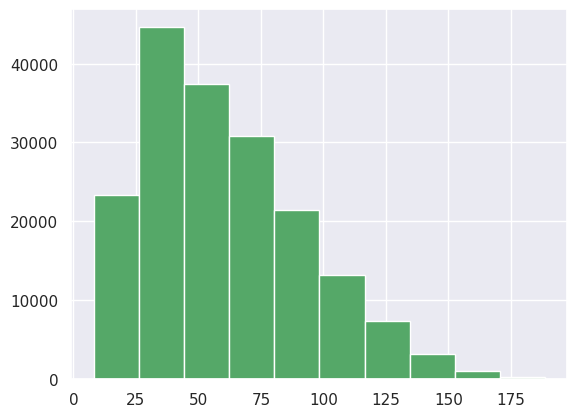

In [ ]:
submission.sales.hist(color = "g");


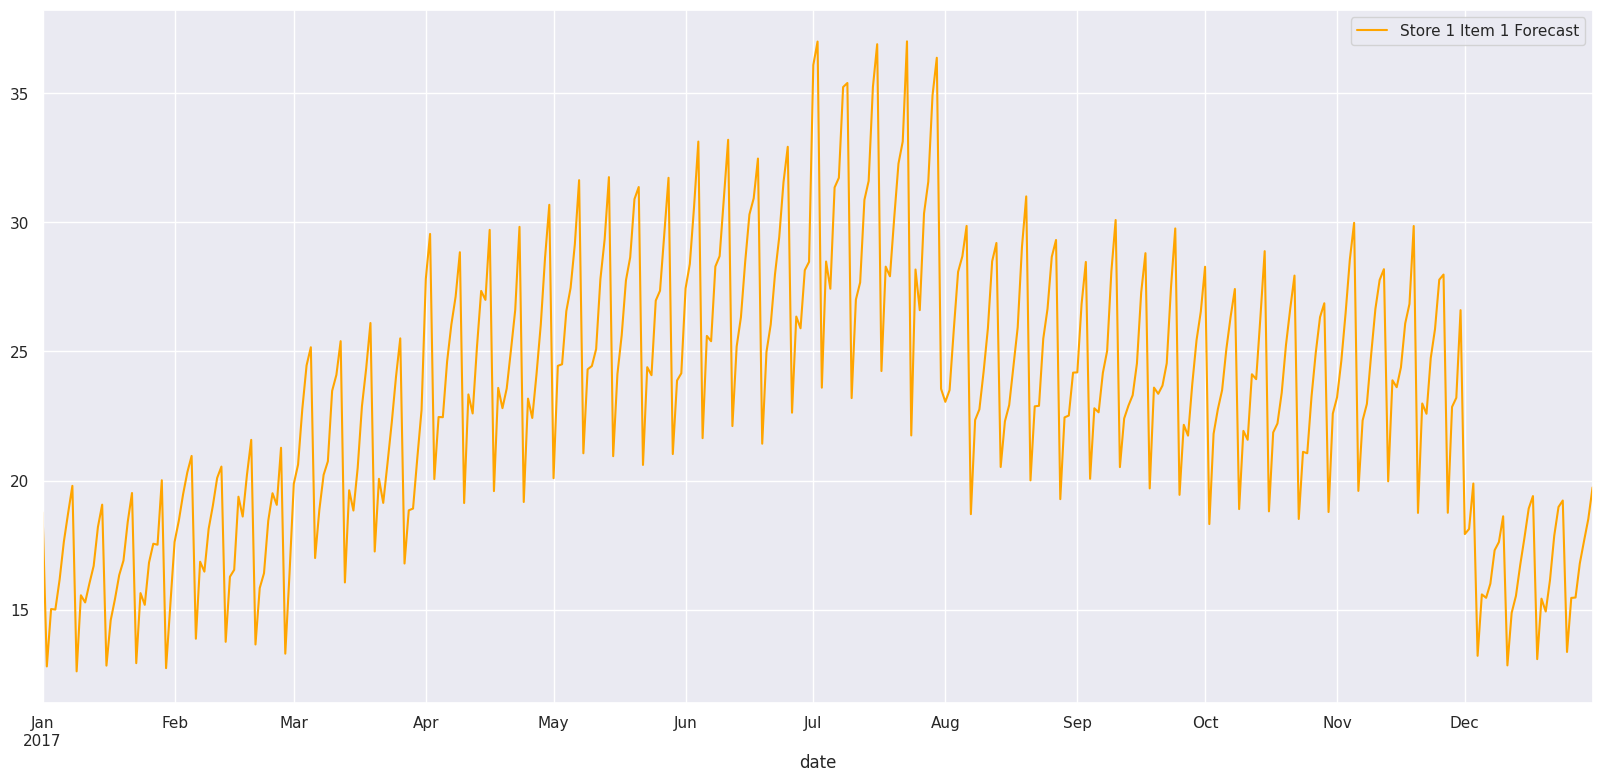

In [ ]:
forecast = pd.DataFrame({
    "date":test_final.date,
    "store":test_final.store,
    "item":test_final.item,
    "sales":final_model.predict(X_test_final)
})

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "orange", figsize = (20,9),legend=True, label = "Store 1 Item 1 Forecast");

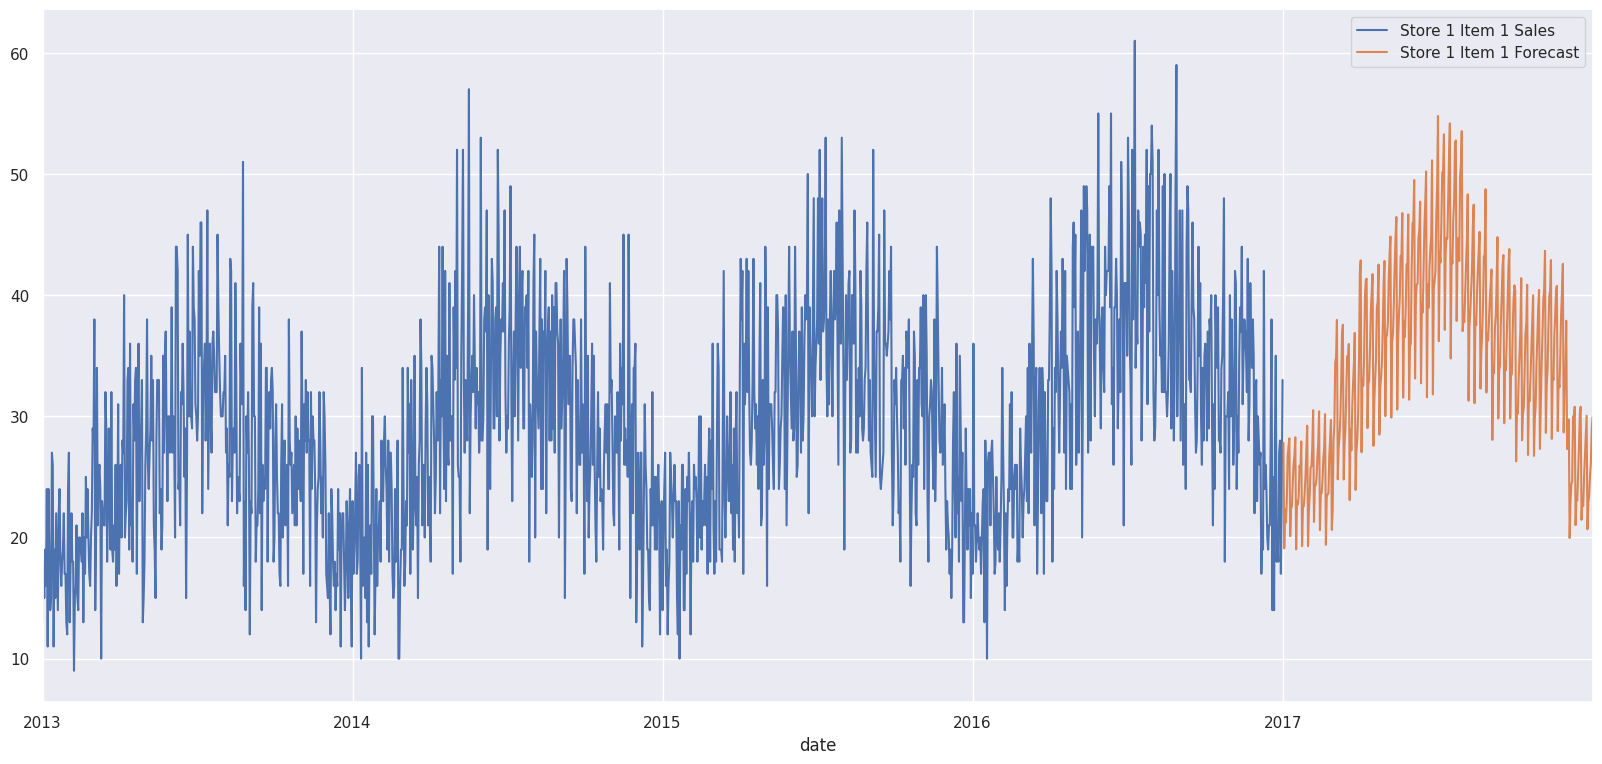

In [ ]:
train_final[(train_final.store == 1) & (train_final.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 1 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 1 Forecast");

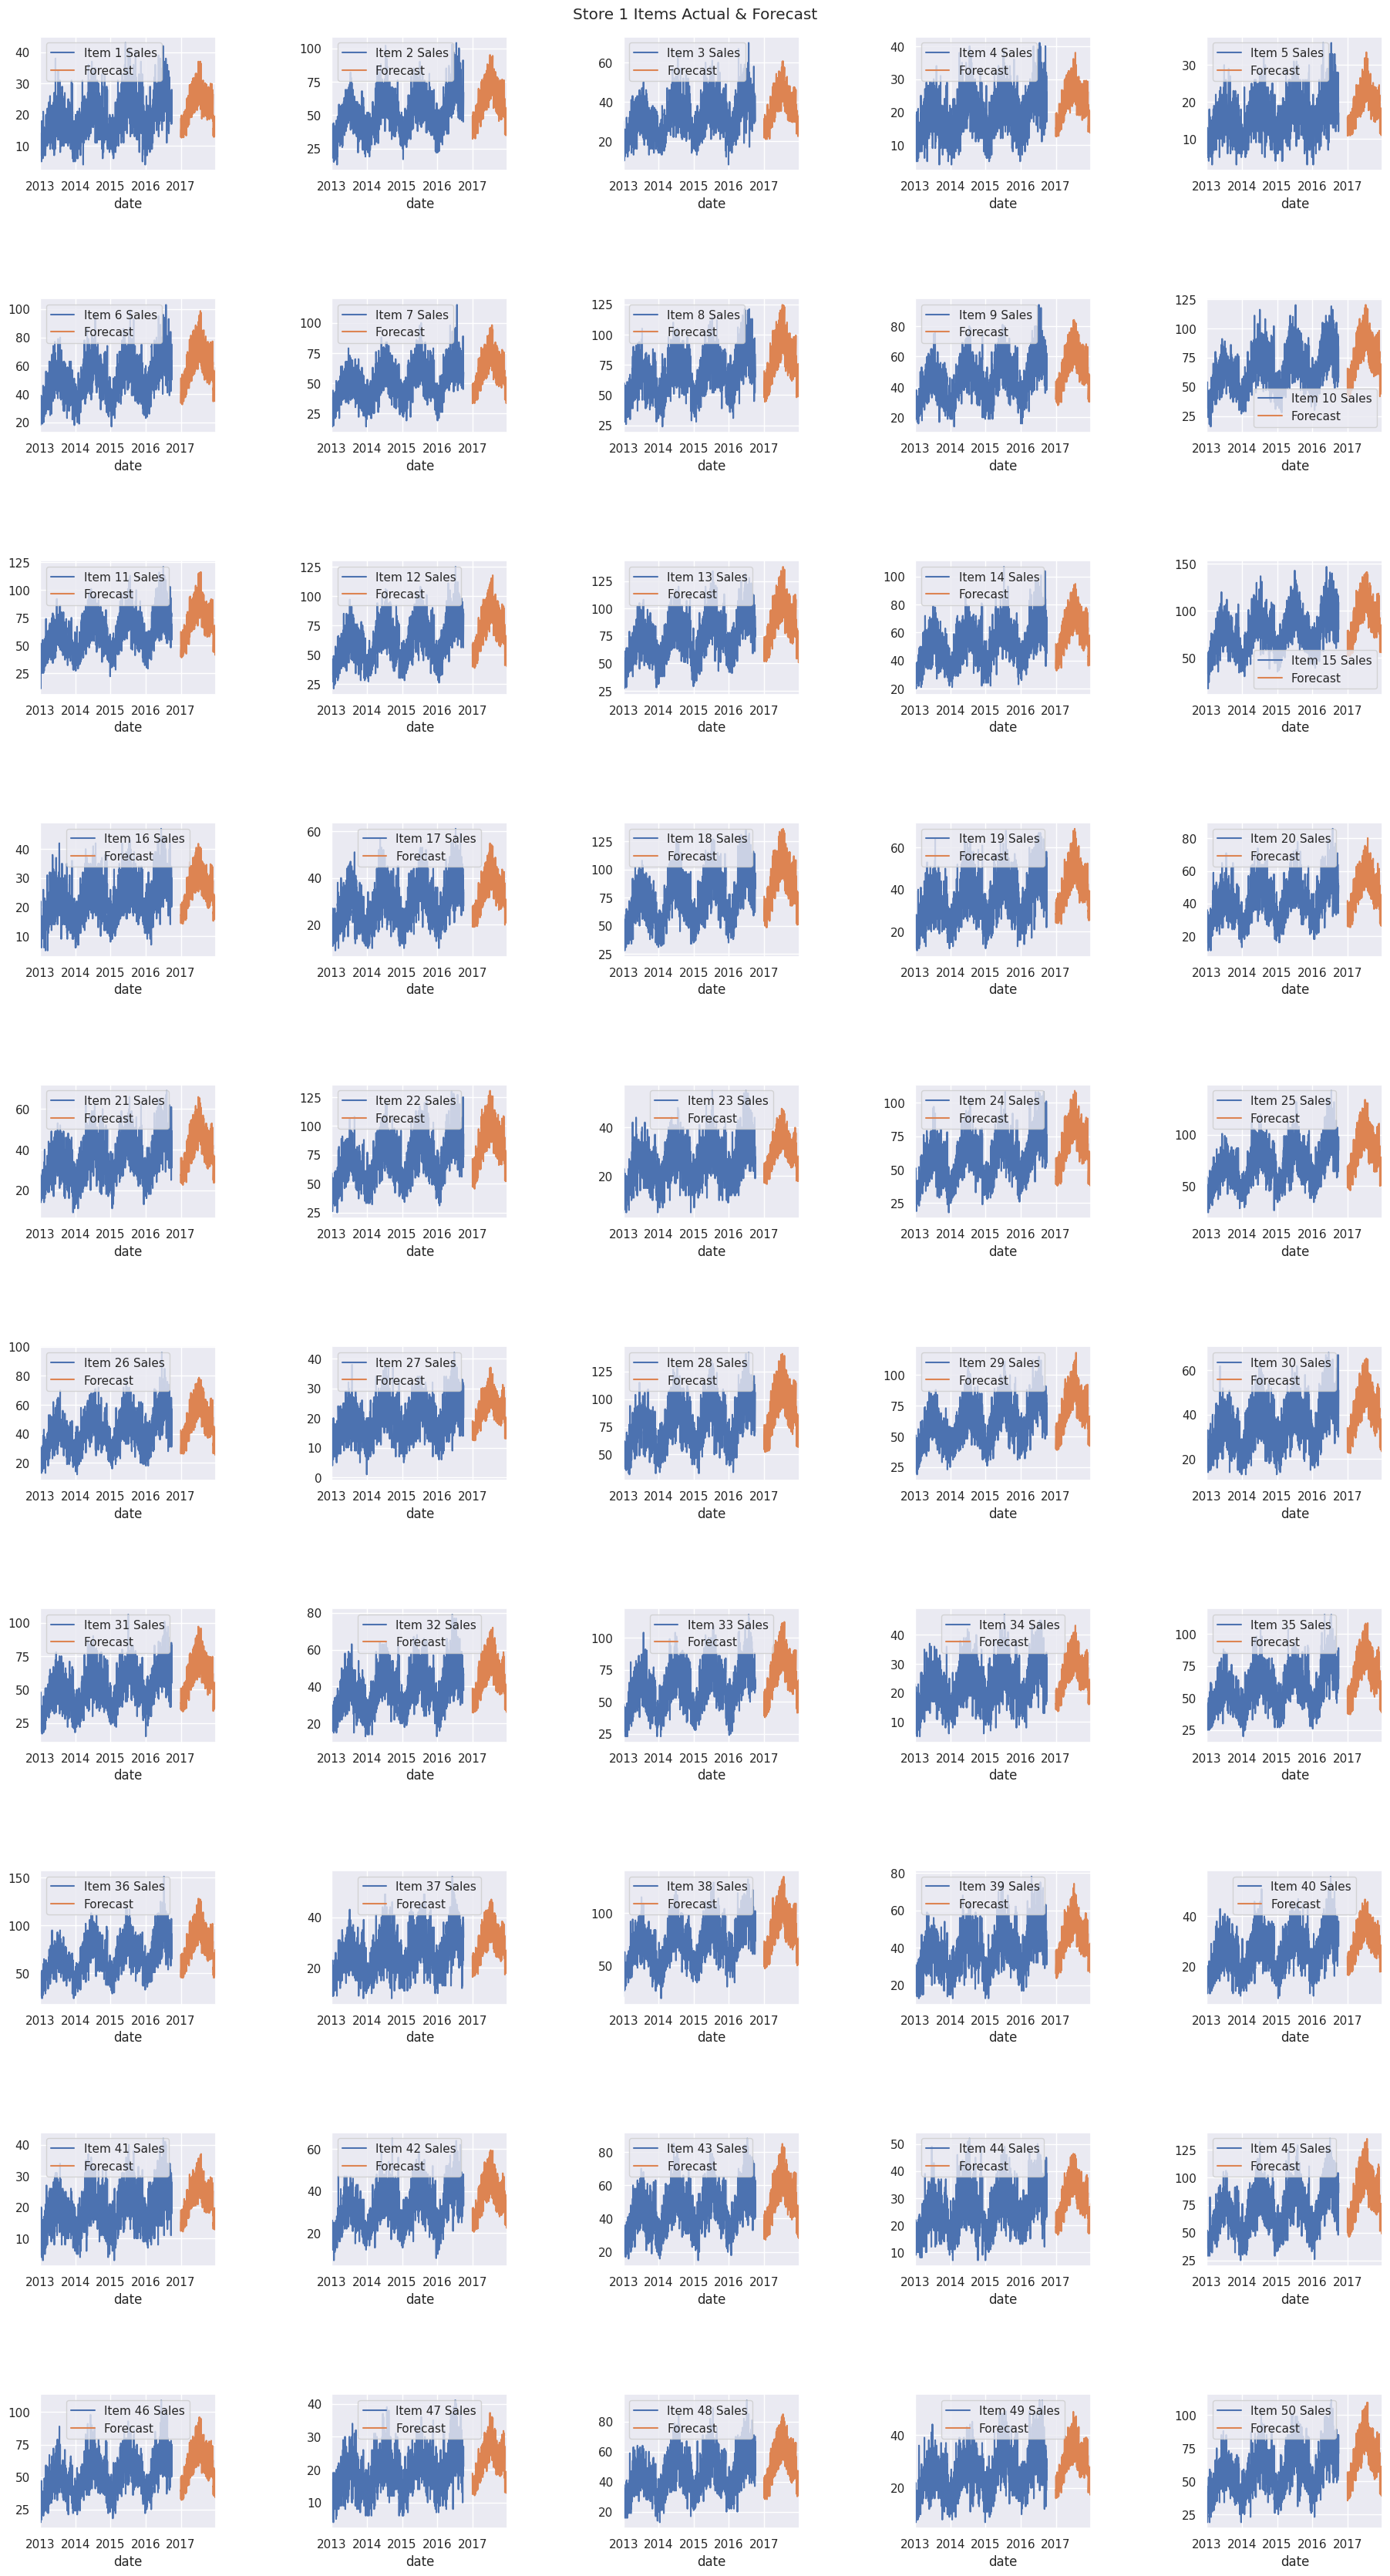

In [ ]:
store = 1
sub = train[train.store == store].set_index("date")
forc = forecast[forecast.store == store].set_index("date")


fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Forecast")
    if i >= 6 and i<11:
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[1, i-6], legend=True, label = "Forecast")
    if i >= 11 and i<16:
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[2, i-11], legend=True, label = "Forecast")
    if i >= 16 and i<21:
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[3, i-16], legend=True, label = "Forecast")
    if i >= 21 and i<26:
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[4, i-21], legend=True, label = "Forecast")
    if i >= 26 and i<31:
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[5, i-26], legend=True, label = "Forecast")
    if i >= 31 and i<36:
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[6, i-31], legend=True, label = "Forecast")
    if i >= 36 and i<41:
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[7, i-36], legend=True, label = "Forecast")
    if i >= 41 and i<46:
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[8, i-41], legend=True, label = "Forecast")
    if i >= 46 and i<51:
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[9, i-46], legend=True, label = "Forecast")
plt.tight_layout(pad=6.5)
plt.suptitle("Store 1 Items Actual & Forecast");

# Results:
### The feature engineering steps provided robust temporal and statistical inputs for the model.
### The two-phase optimization refined the model, resulting in improved SMAPE scores, which serve as a measure of forecasting accuracy.
### The use of LightGBM's feature importance allowed for a more focused second model with a reduced set of key features, balancing model complexity and performance.
### Early stopping ensured that the model did not overfit and could generalize better to unseen data.


# Conclusion:
### The LightGBM-based approach to forecasting has demonstrated promising results, leveraging a combination of temporal feature engineering, statistical tests to understand the data, and sophisticated model optimization techniques. This framework establishes a strong baseline for future explorations and refinements, potentially incorporating other modeling strategies or ensembles for improved accuracy.
